
Session Params:
dt_ms: 0.1, dt_secs: 0.0001, fs_Hz: 10000.0, nyquist_Hz: 5000.0
bandpass filter: sosfilt, f_bp_low_Hz: 1.0, f_bp_high_Hz: 200.0, bandpass_order: 6
wavelet: cgau5, num_scales: 50, scale_low: 1, scale_high: 200

compute_wavelet_transform -- logscales: False
dt_ms: 0.1, wavelet: cgau5, num_scales: 50, scale_low: 1, scale_high: 200
filter_type: sosfilt, fc_low_Hz: 1.0, fc_high_Hz: 200.0, bp_order: 6

compute_wavelet_transform -- logscales: True
dt_ms: 0.1, wavelet: cgau5, num_scales: 50, scale_low: 1, scale_high: 600
filter_type: sosfilt, fc_low_Hz: 1.0, fc_high_Hz: 200.0, bp_order: 6

Note below that STFT is ok but compared to wavelet it smears spectra to the right as window moves across data
Note that Wavelet with linear scales (freqs) shows low freqs that narrow-window stft cannot resolve
Also note that the Wavelet with log scales (freqs) shows expanded low-freq detail


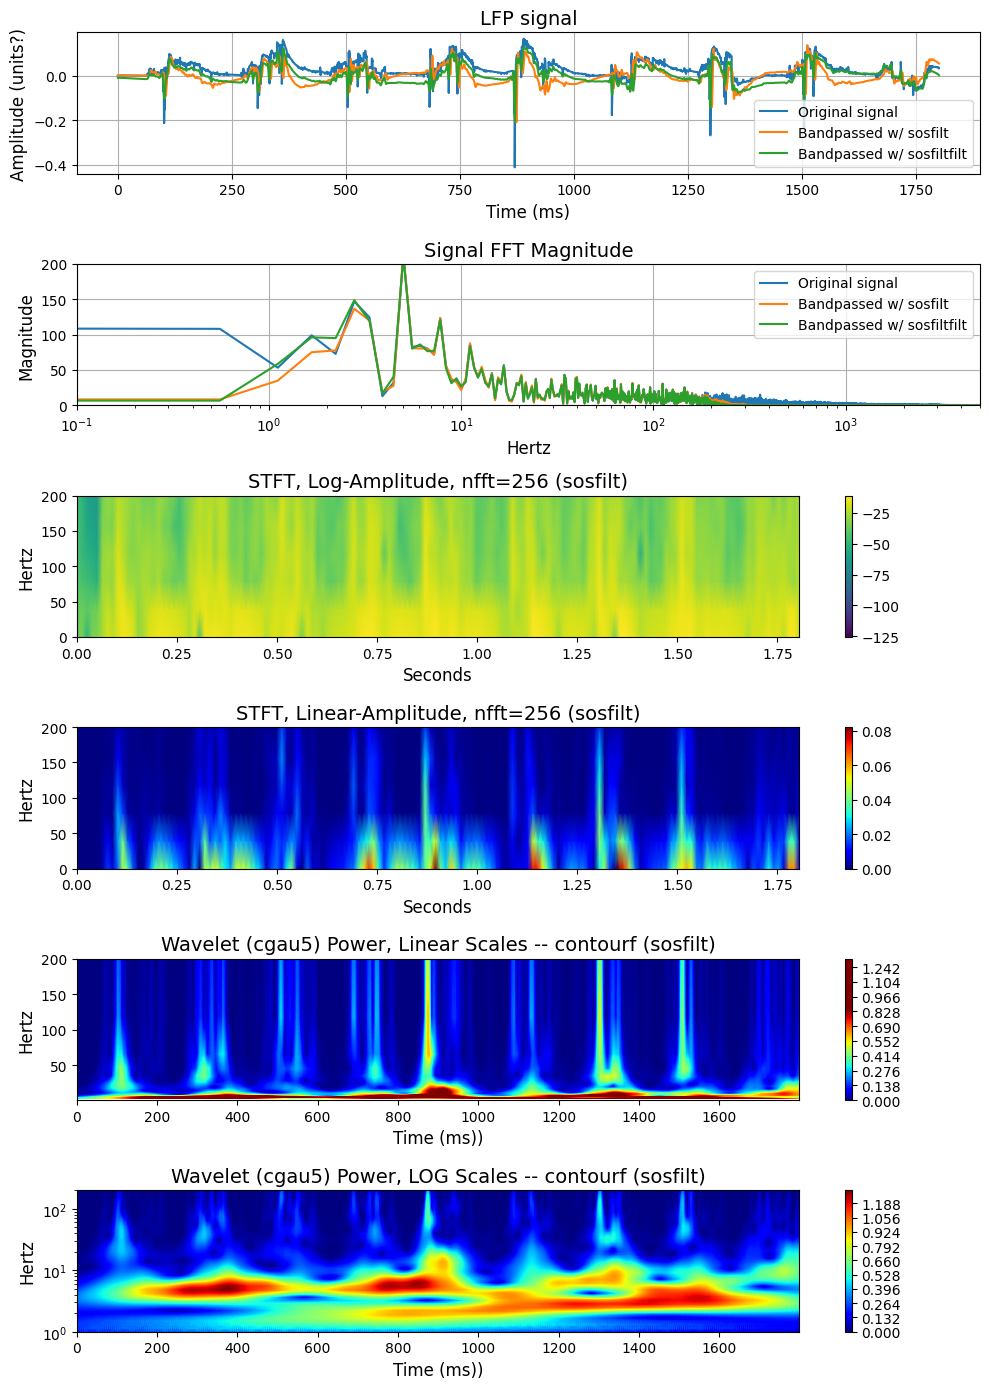


Note below that pcolormesh looks crappy compared to contourf
Also note that Wavelet Coefficient Magnitude has a better dynamic range than Wavelet Power


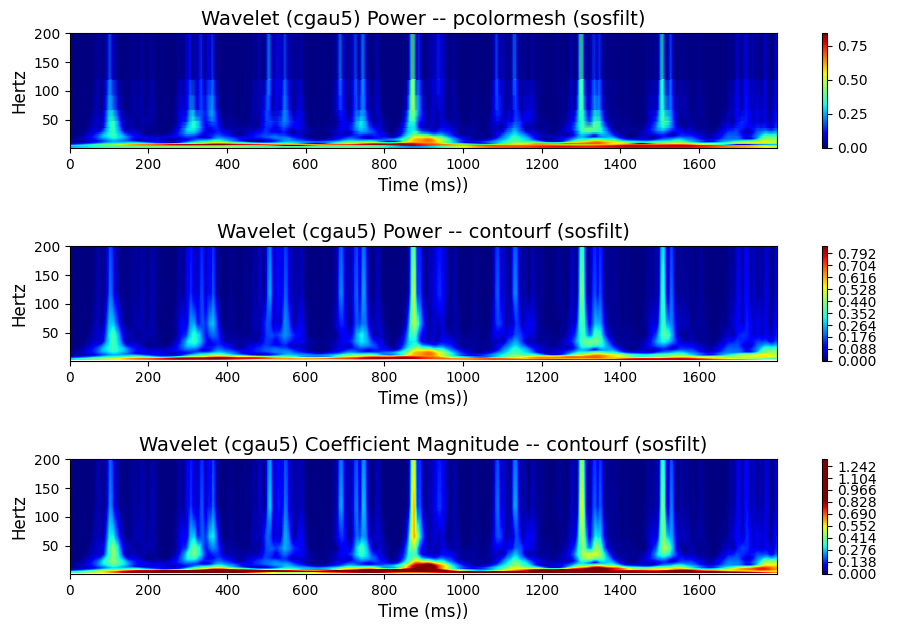


Compare CMOR wavelet for three center-freqs and bandwidths (sosfilt):


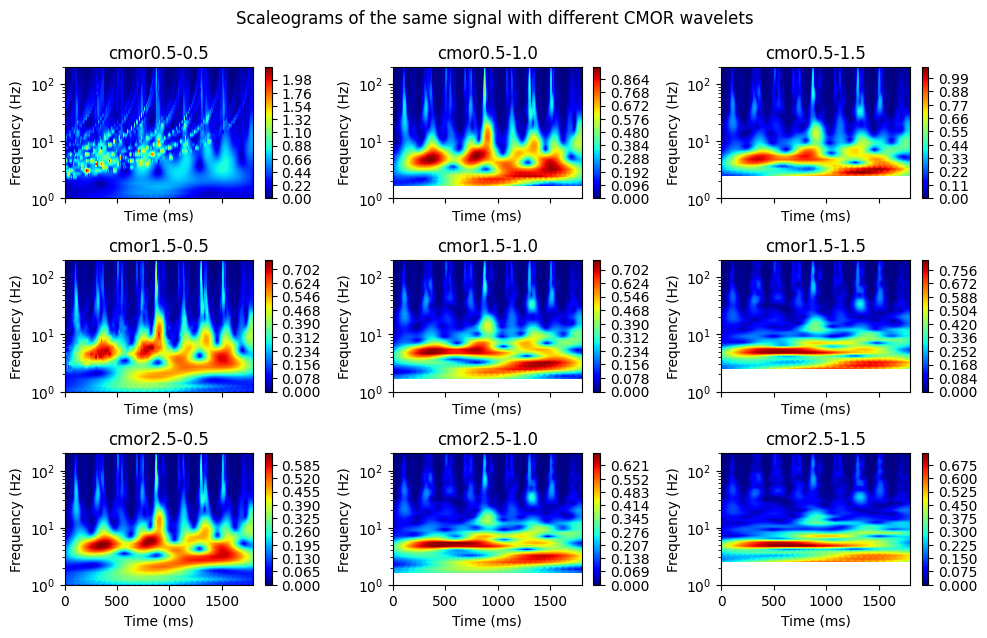


Compare SHAN wavelet for three center-freqs and bandwidths (sosfilt):


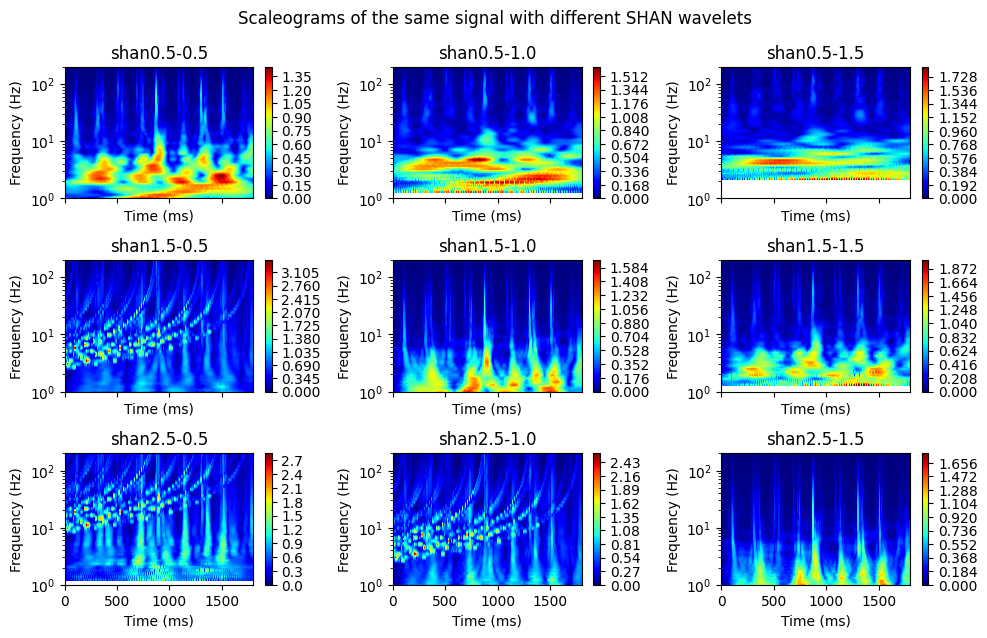

In [3]:
"""
    rfft-stft-wavelet-tests-1.ipynb  (was le-test-4x)
"""
import  numpy as np
import  matplotlib.pyplot as plt
import  matplotlib.ticker as tkr
from    scipy.signal import butter, sosfilt, sosfiltfilt, lfilter, filtfilt, stft
from    scipy.interpolate import interp1d
import  pywt
import  pickle


# -----------------------------------------------------------------------------------------------------------
def bandpass_filter(data, fc_low_Hz, fc_high_Hz, dt_ms, order=6, filter_type='sosfilt'):
    """
    LOCKED CODE -- Bandpass filters the data between fc_low_Hz and fc_high_Hz frequencies.

    Use sosfilt or sosfiltfilt for most filtering tasks, as second-order sections have fewer numerical problems.

    The sosfiltfilt or filtfilt zero-phase filters apply a linear digital filter twice, once forward and once 
    backwards, reulting in zero phase and a filter order twice that of the original.

    Parameters:
        data: array-like, the signal to be filtered
        fc_low_Hz: float, lower cutoff frequency in Hz
        fc_high_Hz: float, higher cutoff frequency in Hz
        dt_ms: float, time step in milliseconds
        order: int, order of the filter
        filter_type: str, 'sosfilt'       # preferred sos: causal
                            'sosfiltfilt'   # preferred sos: zero-phase
                            'lfilter'       # discouraged TF: causal
                            'filtfilt'      # discouraged TF: zero-phase
    Returns:
        y: array-like, the bandpass-filtered signal
    """
    # convert dt in ms to sampling frequency in Hz:
    fs_Hz = 1000.0 / dt_ms
    # Wn units [low, high] are normalized from 0 to 1, where 1 is the Nyquist frequency:
    nyquist = 0.5 * fs_Hz
    low = fc_low_Hz / nyquist
    high = fc_high_Hz / nyquist

    # SOS format, causal:
    if filter_type == 'sosfilt':
        sos = butter(order, [low, high], btype='band', output='sos')    # must NOT have fs passed
        y = sosfilt(sos, data)

    # SOS format, zero-phase:
    elif filter_type == 'sosfiltfilt':
        sos = butter(order, [low, high], btype='band', output='sos')    # must NOT have fs passed
        y = sosfiltfilt(sos, data)

    # TF coefficients, causal:
    elif filter_type == 'lfilter':  
        b, a = butter(order, [fc_low_Hz, fc_high_Hz], fs=fs_Hz, btype='band', output='ba') 
        y = lfilter(b, a, data)

    # TF coefficients, zero-phase:
    elif filter_type == 'filtfilt':
        b, a = butter(order, [fc_low_Hz, fc_high_Hz], fs=fs_Hz, btype='band', output='ba') 
        y = filtfilt(b, a, data)
    else:
        raise ValueError("filter_type must be 'sosfilt', 'sosfiltfilt', 'lfilter', or 'filtfilt'")
    return y


# ----------------------------------------------------------------------------------------
def compute_wavelet_transform(lfp, dt_ms, wavelet='cgau5', num_scales=50, scale_low=1, scale_high=200, \
                              filter_type='sosfilt', fc_low_Hz=1, fc_high_Hz=200, bp_order=6, logscales=False):
    """
    LOCKED CODE -- Computes the continuous wavelet transform of the bandpass-filtered LFP signal.

    Parameters:
        lfp (array):            Local field potential (LFP) signal.
        dt_ms (float):          Time step of the simulation (ms).
        wavelet (str):          Type of wavelet to use.
        num_scales (int):       Number of scales for the wavelet transform.
        scale_low (float):      Lower bound of the scale range.
        scale_high (float):     Upper bound of the scale range.
        filter_type (str):      Bandpass filter type
        fc_low_Hz (float):      Lower bandpass cutoff freq
        fc_high_Hz (float):     Lower bandpass cutoff freq
        bp_order (int):         bandpass filter order
        logscales (bool):             True for log scales, else linear
    Returns:
        tuple: CWT coefficients, frequencies, and wavelet power.
    """

    print(f'\ncompute_wavelet_transform -- logscales: {logscales}')
    print(f'dt_ms: {dt_ms}, wavelet: {wavelet}, num_scales: {num_scales}, scale_low: {scale_low}, scale_high: {scale_high}')
    print(f'filter_type: {filter_type}, fc_low_Hz: {fc_low_Hz}, fc_high_Hz: {fc_high_Hz}, bp_order: {bp_order}')

    dt_secs = dt_ms / 1000.0
    #fs_Hz = 1.0 / dt_secs       # samples_per_second

    # bandpass-filter the LFP signal:
    lfp_bp = bandpass_filter(lfp, fc_low_Hz, fc_high_Hz, dt_ms, order=bp_order, filter_type=filter_type)

    # wavelet scales:
    if (logscales):
        # logarithmic distribution for scales (high-to-low as it is inverse of freq):
        scales = np.geomspace((scale_high / dt_ms), (scale_low / dt_ms), num=num_scales)
        ###print(f'log scales: {scales}')
    else:
        scales = np.linspace((scale_low / dt_ms), (scale_high / dt_ms), num_scales)
        ###print(f'lin scales: {scales}')

    # calc continuous wavelet transform:
    coeffs, frequencies = pywt.cwt(lfp_bp, scales, wavelet, dt_secs)     # must be dt_secs to get Hz
    # calc wavelet power:
    wavelet_power = np.log(1 + abs(coeffs))

    return coeffs, frequencies, wavelet_power 


# ----------------------------------------------------------------------------------------
"""
    from: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#choosing-scales (and tweaked)
"""
def plot_wavelet(signal, dt_ms, wavelet, title, ax, time_ms):
    dt_secs = dt_ms / 1000.0
    # just hard-code scale min/max/num to 1/600/50:
    scales = np.geomspace((1 / dt_ms), (600 / dt_ms), num=50)
    ###scales = np.geomspace(1, 1024, num=75)
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, dt_secs)     # must be dt_secs to get Hz
    coeffs = np.abs(coeffs)    # absolute value of complex coeffs
    #coeffs = np.abs(coeffs[:-1, :-1])  # gives error
    c = ax.contourf(time_ms, freqs, coeffs, 256, cmap='jet')
    ax.set_ylim(1, 200)
    ax.set_yscale("log")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title(title)
    plt.colorbar(c, ax=ax)
    return ax


# ----------------------------------------------------------------------------------------
def linear_interpolate(x, y, dt):
    x = np.array(x)
    y = np.array(y)
    f = interp1d(x, y, kind='linear')
    newx = np.arange(x.min(), x.max(), step=dt)
    newy = f(newx)
    return newx, newy


# ----------------------------------------------------------------------------------------
def main():
    
    # ========== define some defaults:
    dt_ms = 0.1  
    plot_width = 10

    filter_type = 'sosfilt'
    #filter_type = 'sosfiltfilt'    # zero-phase
    f_bp_low_Hz = 1.0
    f_bp_high_Hz = 200.0
    bandpass_order = 6

    # note: using print(pywt.wavelist(kind='continuous'):
    # available wavelets:   'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'fbsp', 
    #                       'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'mexh', 'morl', 'shan'
    wavelet = "cgau5"
    num_scales = 50
    scale_low = 1
    # optimum valuues seem to depend not only on lowest-freq desired, but also on chosen wavelet:
    scale_high = 200            # for cgau5, 200 only gets down to ~3Hz which if fine for linear displays and much faster calc
    scale_high_log = 600        # for cgau5, 600 gets down to ~1Hz for log display

    # init:
    dt_secs = dt_ms / 1000.0
    fs_Hz = 1.0 / dt_secs       # samples_per_second
    nyquist_Hz = fs_Hz / 2.0
    print('\nSession Params:')
    print(f'dt_ms: {dt_ms}, dt_secs: {dt_secs}, fs_Hz: {fs_Hz}, nyquist_Hz: {nyquist_Hz}')
    print(f'bandpass filter: {filter_type}, f_bp_low_Hz: {f_bp_low_Hz}, f_bp_high_Hz: {f_bp_high_Hz}, bandpass_order: {bandpass_order}')
    print(f'wavelet: {wavelet}, num_scales: {num_scales}, scale_low: {scale_low}, scale_high: {scale_high}')


    # ========== open signal file (note: file in current dir):
    with open('./lfp.pkl', 'rb') as f:
        time_ms, lfp_signal = pickle.load(f)

    time_ms = np.array(time_ms)
    lfp_signal = np.array(lfp_signal)
    time_ms, lfp_signal = linear_interpolate(time_ms, lfp_signal, dt_ms)

    # ----- calc bpf of signal:
    lfp_bpf_signal = bandpass_filter(lfp_signal, f_bp_low_Hz, f_bp_high_Hz, dt_ms, order=bandpass_order, filter_type='sosfilt')
    lfp_bpff_signal = bandpass_filter(lfp_signal, f_bp_low_Hz, f_bp_high_Hz, dt_ms, order=bandpass_order, filter_type='sosfiltfilt')

    # ----- calc RFFT:
    xfft = np.fft.rfftfreq(len(lfp_signal), dt_secs)
    yfft = np.fft.rfft(lfp_signal)
    yfftf = np.fft.rfft(lfp_bpf_signal)
    yfftff = np.fft.rfft(lfp_bpff_signal)

    # ----- calc STFT:
    window = 'hann'     # a good general-purpose window function similar to blackman
    nperseg = 256       # segment samples (each segment gets windowed)
    noverlap = 128      # overlap samples (neighboring segment ovelap)
                        # time resolution (time distance between segments aka hop size) is nperseg - noverlap = 128 - 32 = 96 samples
    nfft = 256          # length of the fft must be equal or longer than segment (otherwise you would be truncating samples)
                        # if fft length is longer than segment, the data will be zero-padded
                        # frequency resolution is the sample rate divided by the fft length (not the segment length)
                        # typically use fft length equal to the segment length and overlap of 50%
    padded = True       # zero-pad fft if needed
    freqy, times, spectro = stft(lfp_bpf_signal, fs_Hz, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft, padded=padded)

    # ----- calc Wavelet with linear scales:
    coefficients, freqs, wavelet_power = compute_wavelet_transform(lfp_signal, dt_ms, wavelet, num_scales, scale_low, scale_high, 
                                                                   filter_type, f_bp_low_Hz, f_bp_high_Hz, bandpass_order, logscales=False)
    coeff_mag = np.abs(coefficients)        # absolute value of complex coeffs
    wpmax = abs(wavelet_power).max()
    #fmax = freqs.max()

    # ----- calc Wavelet with LOG scales (set scale_high_log high enough to resolve lowest freq, but slows down calc):
    coefficients_logscales, freqs_logscales, wavelet_power_logscales = compute_wavelet_transform(lfp_signal, dt_ms, wavelet, num_scales, scale_low, scale_high_log, 
                                                                   filter_type, f_bp_low_Hz, f_bp_high_Hz, bandpass_order, logscales=True)
    coeff_mag_logscales = np.abs(coefficients_logscales)    # absolute value of complex coeffs
    wpmax_l = abs(wavelet_power_logscales).max()
    #fmax_l = freqs_logscales.max()


    # ========== intro plots:

    print('\nNote below that STFT is ok but compared to wavelet it smears spectra to the right as window moves across data')
    print('Note that Wavelet with linear scales (freqs) shows low freqs that narrow-window stft cannot resolve')
    print('Also note that the Wavelet with log scales (freqs) shows expanded low-freq detail')

    plt.figure(figsize=(plot_width, (1.4*plot_width)))
    
    # ----- plot signal:
    plt.subplot(6, 1, 1)
    plt.title('LFP signal', fontsize=14)
    plt.plot(time_ms, lfp_signal, label='Original signal')
    plt.plot(time_ms, lfp_bpf_signal, label='Bandpassed w/ sosfilt')
    plt.plot(time_ms, lfp_bpff_signal, label='Bandpassed w/ sosfiltfilt')
    plt.xlabel('Time (ms)', fontsize=12)
    plt.ylabel('Amplitude (units?)', fontsize=12)
    plt.legend()
    plt.grid()

    # ----- plot FFT spectrum:
    plt.subplot(6, 1, 2)
    plt.title(f'Signal FFT Magnitude', fontsize=14)
    plt.semilogx(xfft, np.abs(yfft), label='Original signal')
    plt.semilogx(xfft, np.abs(yfftf), label='Bandpassed w/ sosfilt')
    plt.semilogx(xfft, np.abs(yfftff), label='Bandpassed w/ sosfiltfilt')
    plt.xlabel('Hertz', fontsize=12)
    plt.ylabel('Magnitude', fontsize=12)
    plt.xlim(0.1, nyquist_Hz)
    plt.ylim(0, 200)
    plt.legend()
    plt.grid()

    # ----- plot Log-amplitude STFT:
    plt.subplot(6, 1, 3)
    plt.title('STFT, Log-Amplitude, nfft=256 (sosfilt)', fontsize=14)
    plt.xlabel('Seconds', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.ylim(0, f_bp_high_Hz)
    p = plt.pcolormesh(times, freqy, (10 * np.log10(np.abs(spectro))), shading='gouraud')
    plt.colorbar(p, label=' ')

    # ----- plot Linear-amplitude STFT:
    plt.subplot(6, 1, 4)
    plt.title('STFT, Linear-Amplitude, nfft=256 (sosfilt)', fontsize=14)
    plt.xlabel('Seconds', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.ylim(0, f_bp_high_Hz)
    p = plt.pcolormesh(times, freqy, (np.abs(spectro)), shading='gouraud', cmap='jet')
    plt.colorbar(p, label=' ')

    # ----- plot Wavelet with linear scales (freqs):
    plt.subplot(6, 1, 5)
    plt.title(f'Wavelet ({wavelet}) Power, Linear Scales -- contourf ({filter_type})', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    plt.ylim(f_bp_low_Hz, f_bp_high_Hz)
    c = plt.contourf(time_ms, freqs, coeff_mag, 256, vmin=0, vmax=wpmax, cmap='jet')
    plt.colorbar(c, label=' ')

    # ----- plot Wavelet with LOG scales (freqs):
    plt.subplot(6, 1, 6)
    plt.title(f'Wavelet ({wavelet}) Power, LOG Scales -- contourf ({filter_type})', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    # set 1 Hz min for log scale (and set scale_high_log = 600 to reach ~1Hz):
    plt.ylim(1, f_bp_high_Hz)
    plt.yscale('log')           # must be log
    c = plt.contourf(time_ms, freqs_logscales, coeff_mag_logscales, 256, cmap='jet')
    plt.colorbar(c, label=' ')

    plt.tight_layout()
    plt.show()
    

    # ========== wavelet comparisons -- pcolormesh vs contourf, and wavelet_power vs coeff_mag:

    print('\nNote below that pcolormesh looks crappy compared to contourf')
    print('Also note that Wavelet Coefficient Magnitude has a better dynamic range than Wavelet Power')

    # --- plot:
    plt.figure(figsize=(plot_width, (plot_width/1.5))) 

    plt.subplot(3, 1, 1)
    plt.title(f'Wavelet ({wavelet}) Power -- pcolormesh ({filter_type})', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    plt.ylim(f_bp_low_Hz, f_bp_high_Hz)
    p = plt.pcolormesh(time_ms, freqs, wavelet_power, vmin=0, vmax=wpmax, shading='gouraud', cmap='jet')
    plt.colorbar(p, label=' ')

    plt.subplot(3, 1, 2)
    plt.title(f'Wavelet ({wavelet}) Power -- contourf ({filter_type})', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    plt.ylim(f_bp_low_Hz, f_bp_high_Hz)
    c1 = plt.contourf(time_ms, freqs, wavelet_power, 256, vmin=0, vmax=wpmax, cmap='jet')
    plt.colorbar(c1, label=' ')

    plt.subplot(3, 1, 3)
    plt.title(f'Wavelet ({wavelet}) Coefficient Magnitude -- contourf ({filter_type})', fontsize=14)
    plt.xlabel('Time (ms))', fontsize=12)
    plt.ylabel('Hertz', fontsize=12)
    plt.xlim(min(time_ms), max(time_ms))
    plt.ylim(f_bp_low_Hz, f_bp_high_Hz)
    c2 = plt.contourf(time_ms, freqs, coeff_mag, 256, vmin=0, vmax=wpmax, cmap='jet')
    plt.colorbar(c2, label=' ')

    plt.tight_layout(pad=2.0)
    plt.show()


    # ========== wavelet comparisons -- center frequency and bandwidth (eg: 'cmor1.5-1.0'):
    #
    #   Wavelet can be configured for optimum results using the center_frequency and bandwidth_frequency 
    #   parameters, which can simply be appended to the wavelet’s string identifier cmor for convenience. 
    #   It also demonstrates the importance of choosing appropriate values for the wavelet’s center frequency 
    #   and bandwidth. The right values will depend on the signal being analyzed. 
    #   Bad values may lead to poor resolution or artifacts.
    #   Specify a normalized center frequency -- a value of 1.0 corresponds to 1/dt_secs.
    #   from: https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#choosing-scales (and tweaked)


    print('\nCompare CMOR wavelet for three center-freqs and bandwidths (sosfilt):')

    # perform CWT with different wavelets on same signal and plot results:
    wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
    fig, axs = plt.subplots(3, 3, figsize=(plot_width, (plot_width/1.5)), sharex=True)
    for ax, wavelet in zip(axs.flatten(), wavelets):
        plot_wavelet(lfp_bpf_signal, dt_ms, wavelet, title=wavelet, ax=ax, time_ms=time_ms)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Scaleograms of the same signal with different CMOR wavelets")
    plt.show()


    print('\nCompare SHAN wavelet for three center-freqs and bandwidths (sosfilt):')

    # perform CWT with different wavelets on same signal and plot results:
    wavelets = [f"shan{x:.1f}-{y:.1f}" for x in [0.5, 1.5, 2.5] for y in [0.5, 1.0, 1.5]]
    fig, axs = plt.subplots(3, 3, figsize=(plot_width, (plot_width/1.5)), sharex=True)
    for ax, wavelet in zip(axs.flatten(), wavelets):
        plot_wavelet(lfp_bpf_signal, dt_ms, wavelet, title=wavelet, ax=ax, time_ms=time_ms)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Scaleograms of the same signal with different SHAN wavelets")
    plt.show()


    # For wavelets of family fbsp, the name should take the form fbspM-B-C where M is the spline order and B, C 
    # are floats representing the bandwidth frequency and center frequency, respectively (example: fbsp1-1.5-1.0).



# ----------------------------------------------------------------------------------------
if __name__ == "__main__":
    main()
# ----------------------------------------------------------------------------------------
